<a href="https://colab.research.google.com/github/24p11/recode-scenario/blob/main/scenario_oncology_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Create fictive clinical notes from Code set (DRG + ICD)

Code set are the raw classification data, we can extract from National database (Base nationale PMSI en France). They are made of 
* classification profile made of grouping variables from DRG records which are prepared with their frequency in the national database
    - age (class)
    - sexe
    - DRG (racine GHM)
    - Main diagnosis (ICD10) : cf
    - Hospitalization management type : cf
* diagnosis associated to each classification profile, extracted with their frequencies
* procedures associated to each classification profile, specialy for surgery and technical gestures, extracted with their frequencies

From thoses raw information we produce a coded clinical scenario which will be uses a seed.

This scenario is transformed into a detail prompt that will be given to a LLM for generation.
From the combinaision of primary and related diagnosis in French discharge abstract, we derived two notions :
* Primary diagnosis : host the notion of principal pathology, it is rather the primary diagnosis of the discharge abstract or the related diagnosis when it exists and that the primary diagnosis of the discharge abstract is from the chapter "Facteurs influant sur l’état de santé" of ICD10
* The Hospitalization management type is rather the term "Primary diagnosis" or the ICD-10 code of the related diagnosis when it exists


In [1]:
#Number of scenarios generate
N_SCENARIO = 20

#Filters to apply to the initial national data
#Here: patient not cancer ; None if no filters
#QUERY = "icd_primary_code.isin(@gs.icd_codes_cancer)"
QUERY = None

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
from utils import *

In [4]:
gs = generate_scenario()
# Load official dictionaries
# col_names option allow you to algin your column names the project dictionary.
gs.load_offical_icd("cim_2024.xlsx",col_names={"code" : "icd_code","libelle":"icd_code_description"} )
gs.load_offical_procedures("ccam_actes_2024.xlsx",col_names={"code":"procedure","libelle_long":"procedure_description"} )
col_names={"Code CIM":"icd_parent_code","Localisation":"primary_site","Type Histologique":"histological_type",
           "Stade":"stage","Marqueurs Tumoraux":"biomarkers","Traitement":"treatment_recommandation","Protocole de Chimiothérapie":"chemotherapy_regimen"}
gs.load_cancer_treatement_recommandations("Tableau récapitulatif traitement cancer.xlsx",col_names ) 
col_names={"racine":"drg_parent_code","lib_spe_uma":"specialty","ratio_spe_racine":"ratio"}
gs.load_specialty_refential("dictionnaire_spe_racine.xlsx",col_names)
gs.load_referential_hospital("chu")
gs.load_exclusions("exclusions")

# Load data from BN  PMSI
col_names={"racine":"drg_parent_code","das": "icd_secondary_code","diag":"icd_primary_code","categ_cim":"icd_primary_parent_code",
            "mdp":"case_management_type","nb_situations":"nb","acte":"procedure",
            "mode_entree":"admission_mode",
            "mode_sortie":"discharge_disposition",
            "mode_hospit":"admission_type"}

gs.load_classification_profile("bn_pmsi_cases_20250819.csv", col_names)
gs.load_secondary_icd("bn_pmsi_related_diag_20250818.csv",col_names)
gs.load_procedures("bn_pmsi_procedures_20250818.csv",col_names)

In [6]:
#Prepare cases
df_profile = gs.df_classification_profile

array([[<AxesSubplot:title={'center':'nb'}>]], dtype=object)

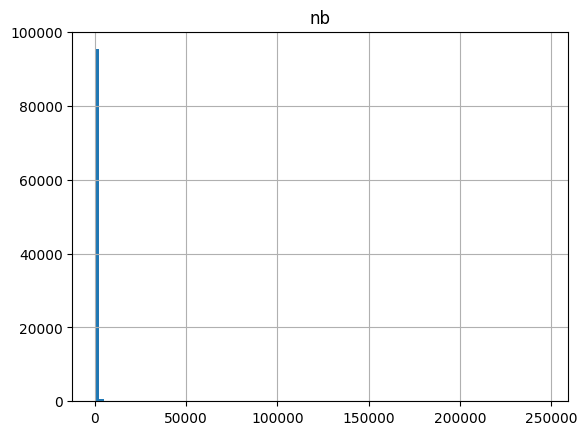

In [7]:
df_profile.hist(column="nb",bins=100)

In [8]:
n_tot_r = np.sum(df_profile.nb)
df_profile = df_profile.assign(effectif = df_profile.nb,
                    effectif_trans = np.sqrt(df_profile.nb)*1000000000/n_tot_r)
df_profile = df_profile.assign(effectif_final = np.where(df_profile.effectif_trans>1500,1500,df_profile.effectif_trans))


array([[<AxesSubplot:title={'center':'effectif_final'}>]], dtype=object)

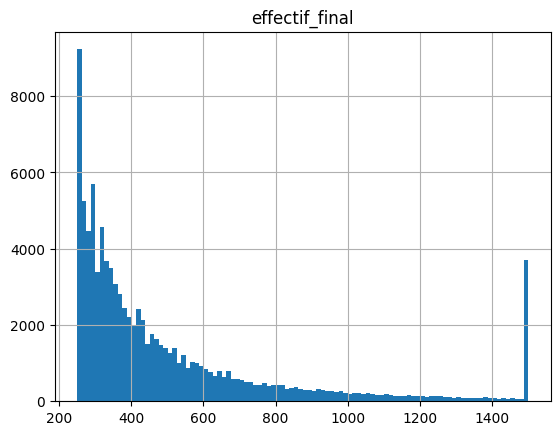

In [9]:
df_profile.hist(column="effectif_final",bins=100)

In [10]:
#Exclusion 
#G178	Transplantations d'organes
#G187	Séances : dialyse
#G189	Séances : radiothérapie
df_profile = df_profile[(~df_profile.ga.isin(gs.df_exclusions.ga) ) &(~df_profile.specialty.isin(["OBSTETRIQUE","NEONATOLOGIE"])) ]
print("Total classification profiles :  " + (str(len(df_profile))))

icd_codes_cancer = gs.icd_codes_cancer

Total classification profiles :  92462


# Sampling

In [11]:
QUERY = "icd_primary_code.isin(@gs.icd_codes_cancer) and case_management_type=='Z511'"
df_profile_sample= df_profile.query(QUERY).iloc[:1,:]
QUERY = "icd_primary_code.isin(@gs.icd_codes_cancer) and case_management_type=='DP'"
df_profile_sample = pd.concat([df_profile_sample,df_profile.query(QUERY).iloc[:3,:]],axis=0)
QUERY =  "icd_primary_code.isin(@gs.icd_codes_chronic_attack) and case_management_type=='DP'"
df_profile_sample = pd.concat([df_profile_sample,df_profile.query(QUERY).iloc[:2,:]],axis=0)
QUERY =  "icd_primary_code.isin(@gs.icd_codes_diabetes_chronic) and case_management_type=='DP'"
df_profile_sample = pd.concat([df_profile_sample,df_profile.query(QUERY).iloc[:2,:]],axis=0)
QUERY = " (~ icd_primary_code.isin(@gs.icd_codes_chronic) )  and case_management_type=='DP'"
df_profile_sample = pd.concat([df_profile_sample,df_profile.query(QUERY).iloc[:2,:]],axis=0)
QUERY = " drg_parent_code.isin(@gs.drg_parents_groups_csection)  and case_management_type=='DP'"
df_profile_sample = pd.concat([df_profile_sample,df_profile.query(QUERY).iloc[:2,:]],axis=0)
df_profile_sample.drop(columns=["nb","effectif","effectif_trans","effectif_final"],inplace=True)

In [12]:
#QUERY = " drg_parent_code.isin(@gs.drg_parents_groups_csection)  and case_management_type=='DP'"
#df_profile.query(QUERY).iloc[:3,:]


In [13]:
#Exclude some rows regarding QUERY
#if QUERY is not None : 
#    df_profile_sample = df_profile.query(QUERY)
#else :
#    df_profile_sample = df_profile.copy()
#df_profile_sample = df_profile_sample.sample(N_SCENARIO, weights="effectif_final").reset_index(drop=True)
#df_profile_sample.drop(columns=["nb","effectif","effectif_trans","effectif_final"],inplace=True)

In [14]:
list_scenario = []

for i in tqdm(range(len(df_profile_sample))):
# for i in tqdm(range(1)):
    profile = df_profile_sample.iloc[i].copy()
    scenario = gs.generate_scenario_from_profile(profile)
    row = {k:scenario[k] for k in scenario.keys()}
    user_prompt = gs.make_prompts_marks_from_scenario(scenario)
    system_prompt = gs.create_system_prompt(scenario)
    row["user_prompt"] = user_prompt
    row["system_prompt"] = system_prompt
    
    if  scenario["icd_primary_code"]  in gs.icd_codes_cancer  :
        prefix = """Le compte rendu suivant respecte les élements suivants :
        - les diagnostics ont une formulation moins formelle que la définition du code
        - le type histologique et la valeur des biomarqueurs si recherchés
        - le plan du CRH est conforme aux recommandations.
        """
    else :
        prefix = """Le compte rendu suivant respecte les élements suivants :
        - les diagnostics ont une formulation moins formelle que la définition du code
        - le plan du CRH est conforme aux recommandations.
        """
    
    row["prefix"] = prefix
    row["prefix_len"] = len(prefix)
    list_scenario.append(row)

100%|██████████| 12/12 [01:17<00:00,  6.44s/it]


In [17]:
print[x for x in list_scenario[0]]

['age',
 'sexe',
 'date_entry',
 'date_discharge',
 'date_of_birth',
 'first_name',
 'last_name',
 'icd_primary_code',
 'case_management_type',
 'icd_secondaray_code',
 'procedure',
 'icd_primary_description',
 'admission_mode',
 'discharge_disposition',
 'cancer_stage',
 'score_TNM',
 'histological_type',
 'treatment_recommandation',
 'chemotherapy_regimen',
 'biomarkers',
 'department',
 'hospital',
 'first_name_med',
 'last_name_med',
 'template_name',
 'drg_parent_code',
 'cage',
 'cage2',
 'admission_type',
 'dms',
 'los_mean',
 'los_sd',
 'drg_parent_description',
 'da',
 'libelle_da',
 'gp_cas',
 'libelle_gp_cas',
 'ga',
 'libelle_ga',
 'da_gp',
 'da_gp_ga',
 'anseqta',
 'aso',
 'specialty',
 'icd_parent_code',
 'departement',
 'case_management_type_description',
 'text_secondary_icd_official',
 'text_procedure',
 'case_management_type_text',
 'coding_rule',
 'case_management_description',
 'user_prompt',
 'system_prompt',
 'prefix',
 'prefix_len']

In [16]:
keep_cols = ['age',  'cage', 'cage2','sexe', 'date_entry', 'date_discharge', 'date_of_birth',
       'first_name', 'last_name', 'icd_primary_code', 'icd_primary_description', 'icd_parent_code',
       'case_management_type','case_management_type_description', 'coding_rule','case_management_type_text', 
       'drg_parent_code', 'drg_parent_description',
       'icd_secondaray_code',  'text_secondary_icd_official', 
        'procedure', 'text_procedure',
        'admission_type','admission_mode', 'discharge_disposition', 'dms', 'los_mean', 'los_sd',
       'cancer_stage', 'score_TNM', 'histological_type',
       'treatment_recommandation', 'chemotherapy_regimen', 'biomarkers',
       'first_name_med', 'last_name_med',
       'department','hospital','user_prompt', 'system_prompt', 'prefix', 'prefix_len']
df_scenario = pd.DataFrame(list_scenario)[keep_cols]
df_scenario.to_csv("results/generated_scenarios_"+dt.datetime.now().strftime('%Y%m%d_%H%M')+".csv")

In [20]:
keep_cols = ['icd_primary_code', 'icd_primary_description', 'icd_parent_code',
       'case_management_type','case_management_type_description', 'case_management_type_text', 
       'drg_parent_code', 'text_procedure','coding_rule',       
       'user_prompt']
df_scenario[keep_cols].loc[0]

icd_primary_code                                                                 C833
icd_primary_description                          Lymphome diffus à grandes cellules B
icd_parent_code                                                                   C83
case_management_type                                                             Z511
case_management_type_description                 Séance de chimiothérapie pour tumeur
case_management_type_text           Pour prise en charge en hospialisation complèt...
drg_parent_code                                                                 17M06
text_procedure                      Biopsie d'un os et/ou d'une articulation du me...
coding_rule                                                                          
user_prompt                         **SCÉNARIO DE DÉPART :**\n- Âge du patient : 7...
Name: 0, dtype: object

In [22]:
gs.define_text_managment_type(df_scenario.loc[1])

('Hospitalisation pour prise en charge du cancer',
 'other',
 'medical_inpatient.txt')

In [47]:
for i in range(0,12):
    print(df_scenario.loc[i,"icd_primary_code"])
    print(df_scenario.loc[i,"case_management_type"])
    print(df_scenario.loc[i,"drg_parent_code"])
    
    cmt,coding_rule,template = gs.define_text_managment_type(df_scenario.loc[i])
    print(coding_rule)
    if coding_rule in gs.coding_rules : 
        print(gs.coding_rules[coding_rule]['texte'])
    else:
        print("No conding rule")
    print("+++++++++++++++++++++++++++++++")

C833
Z511
17M06
T1
HOSPITALISATION POUR TRAITEMENT. La situation est celle d’un patient atteint d’une affection connue, diagnostiquée avant l’admission, hospitalisé pour le traitement de celle-ci. Les circonstances du diagnostic préalable n’importent pas : le diagnostic de l’affection a pu être fait par un médecin généraliste ou spécialiste « de ville », par un service médical d’urgence et de réanimation (SMUR), lors du passage dans une structure d’accueil des urgences, lors d’un séjour précédent dans une autre unité médicale, y compris l’unité d’hospitalisation de courte durée, du même établissement de santé ou d’un autre, etc. La situation de traitement est présente lorsque le diagnostic de l’affection est fait au moment de l’entrée du patient dans l’unité médicale et que l’admission a pour but le traitement de l’affection. On se situe ici dans le cadre d'un traitement répétitif c'est à dire un traitement qui, par nature, imposent une administration répétitive. En d’autres termes, dè

In [41]:
gs.drg_parents_groups_delivery

['14C03',
 '14Z09',
 '14Z10',
 '14Z11',
 '14Z12',
 '14Z13',
 '14Z14',
 '14C06',
 '14C07',
 '14C08']

In [33]:
df_scenario.loc[1,"drg_parent_code"][2:3]=="K"

True

In [35]:
regK = re.compile(r'K|k')
if regexp.search(df_scenario.loc[1,"drg_parent_code"][2:3]):
    print("True")

True


In [37]:
gs.df_chronic[gs.df_chronic.code.isin(gs.icd_codes_cancer)]

,code,chronic,libelle
925,C00,3,Tumeur maligne de la lèvre
926,C000,3,"Tumeur maligne de la lèvre supérieure, (bord l..."
927,C001,3,"Tumeur maligne de la lèvre inférieure, (bord l..."
928,C002,3,"Tumeur maligne de la lèvre, sans précision, bo..."
929,C003,3,"Tumeur maligne de la lèvre supérieure, face in..."
...,...,...,...
1847,D484,3,Tumeur à évolution imprévisible du péritoine
1848,D485,3,Tumeur à évolution imprévisible et inconnue de...
1849,D486,3,Tumeur à évolution imprévisible et inconnue du...
1850,D487,3,Tumeur à évolution imprévisible et inconnue d'...


In [42]:
gs.df_chronic[gs.df_chronic.code.isin(["C833"])]

,code,chronic,libelle
1396,C833,3,Lymphome diffus à grandes cellules B


In [45]:
gs.df_chronic.code[gs.df_chronic.chronic.isin([1,2,3]) & (gs.df_chronic.code.isin(["C833"])) ]

1396    C833
Name: code, dtype: object

In [50]:
pd.read_csv(gs.path_ref + "procedure_botulic_toxine.csv",sep=";").code.to_list()

['BALB001', 'BJLB001', 'LCLB001', 'PCLB002', 'PCLB003']